<a href="https://colab.research.google.com/github/hrtnisri2016/fcc-ml-python-projects/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Health Costs Calculator

In this notebook, I use a linear regression algorithm to predict healthcare costs given a dataset that contains data on various people, including their healthcare costs. 

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, Sequential, optimizers

In [2]:
tf.__version__

'2.9.2'

In [3]:
plt.style.use('ggplot')

## Import data

In [4]:
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-12-27 12:53:25--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.009s  

2022-12-27 12:53:25 (5.47 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Data cleaning

In [6]:
# check the unique value for every categorical data
for col in ['sex', 'smoker', 'region']:
    print(dataset[col].unique())

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


In [7]:
# make a copy of dataset
df = dataset.copy()

**Detect and remove the outliers using interquartile range (IQR)**

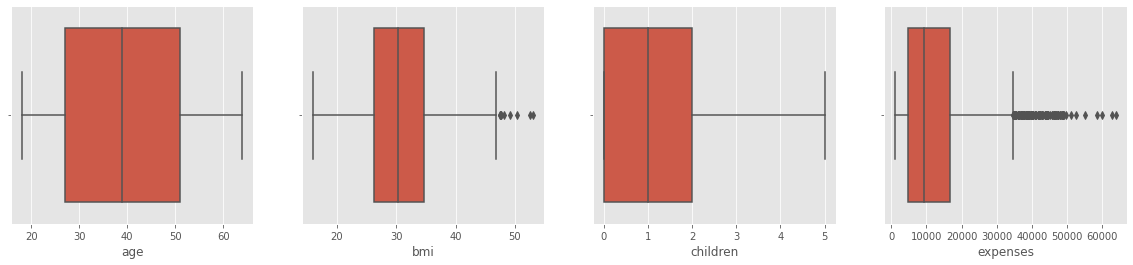

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

sns.boxplot(x='age', data=df, ax=axes[0])
sns.boxplot(x='bmi', data=df, ax=axes[1])
sns.boxplot(x='children', data=df, ax=axes[2])
sns.boxplot(x='expenses', data=df, ax=axes[3])

plt.show()

In [9]:
def remove_outliers(data, column_name):
    # IQR
    Q1 = np.percentile(data[column_name], 25, interpolation='midpoint')
    Q3 = np.percentile(data[column_name], 75,interpolation='midpoint')
    IQR = Q3 - Q1
    print("Old Shape: ", data.shape)

    # Upper bound
    upper = np.where(data[column_name] >= (Q3+1.5*IQR))
    # Lower bound
    lower = np.where(data[column_name] <= (Q1-1.5*IQR))

    # Remove outliers
    data.drop(upper[0], inplace = True)
    data.drop(lower[0], inplace = True)

    data.reset_index(drop=True, inplace = True)
    print("New Shape: ", data.shape)
    return data

In [10]:
df = remove_outliers(df, 'bmi')

Old Shape:  (1338, 7)
New Shape:  (1329, 7)


In [11]:
df = remove_outliers(df, 'expenses')

Old Shape:  (1329, 7)
New Shape:  (1191, 7)


In [12]:
# encode binary feature
df['sex'].replace({'male': 1, 'female': 0}, inplace=True)
df['smoker'].replace({'yes': 1, 'no': 0}, inplace=True)

In [13]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,southwest,16884.92
1,18,1,33.8,1,0,southeast,1725.55
2,28,1,33.0,3,0,southeast,4449.46
3,33,1,22.7,0,0,northwest,21984.47
4,32,1,28.9,0,0,northwest,3866.86
...,...,...,...,...,...,...,...
1186,50,1,31.0,3,0,northwest,10600.55
1187,18,0,31.9,0,0,northeast,2205.98
1188,18,0,36.9,0,0,southeast,1629.83
1189,21,0,25.8,0,0,southwest,2007.95


## Split the data into training and test sets

Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

In [14]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. 

In [15]:
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

## Build a preprocessing model

A preprocessing model will apply appropriate preprocessing to each input.

In [16]:
binary_feature = ['sex', 'smoker'] 
categorical_feature = ['region']

In [17]:
inputs = {}
for name, column in train_dataset.items():
    if type(column[0]) == str:
        dtype = tf.string
    elif (name in categorical_feature or 
          name in binary_feature):
        dtype = tf.int64
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

In [18]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'bmi': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'bmi')>,
 'children': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'children')>,
 'smoker': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'smoker')>,
 'region': <KerasTensor: shape=(None,) dtype=string (created by layer 'region')>}

Since the binary inputs don't need any preprocessing, just add the vector axis, cast them to `float32` and add them to the list of preprocessed inputs.

In [19]:
preprocessed = []

for name in binary_feature:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>]

For numeric inputs, run them through a `tf.keras.layers.Normalization` layer before using them. Input them as a dict. The code below collects the numeric features from the DataFrame, stacks them together and passes those to the `Normalization.adapt` method.

In [20]:
# You write a subclass of tf.keras.Model (or tf.keras.Layer). 
# You directly handle the inputs, and create the outputs:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))
    return fun(values, axis=-1)

In [21]:
numeric_feature_names = ['age', 'bmi', 'children'] 
numeric_features = train_dataset[numeric_feature_names]

In [22]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

In [23]:
# Stacks the numeric features and runs them through the normalization layer
numeric_inputs = {}
for name in numeric_feature_names:
    numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)
preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization')>]

To use categorical feature `region`, encode it into embeddings. Since the feature only contain a small number of categories, convert the inputs directly to one-hot vectors using the `output_mode='one_hot'` option, supported by the `tf.keras.layers.StringLookup` layer.

To determine the vocabulary for each input, create a layer to convert that vocabulary to a one-hot vector.

In [24]:
name = categorical_feature[0]
vocab = sorted(set(train_dataset[name]))
print(f'name: {name}')
print(f'vocab: {vocab}\n')

lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
x = inputs[name][:, tf.newaxis]
x = lookup(x)
preprocessed.append(x)

name: region
vocab: ['northeast', 'northwest', 'southeast', 'southwest']



In [25]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'string_lookup')>]

At this point `preprocessed` is just a Python list of all the preprocessing results, each result has a shape of `(batch_size, depth)`.

Concatenate all the preprocessed features along the `depth` axis, so each dictionary-example is converted into a single vector. The vector contains binary features, numeric features, and categorical feature.

In [26]:
# Assemble the preprocessing head
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'tf.concat')>

Now create a model out of that calculation so it can be reused. 

In [27]:
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

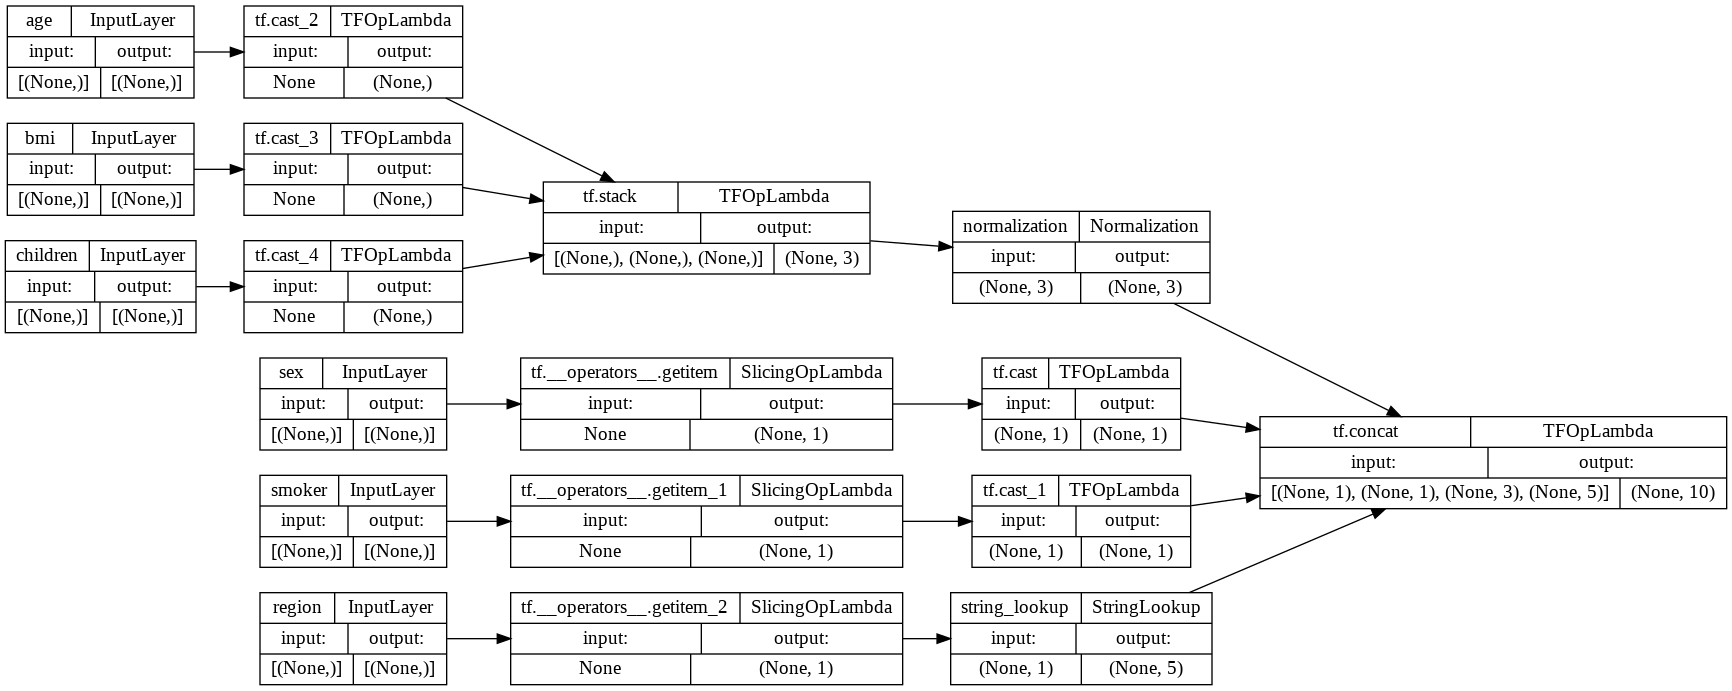

In [28]:
# visualize the connectivity graph
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

To test the preprocessor, use the `DataFrame.iloc` accessor to slice the first example from the DataFrame. Then convert it to a dictionary and pass the dictionary to the preprocessor. The result is a single vector containing the binary features, normalized numeric features and the one-hot categorical features, in that order.

In [29]:
preprocessor(dict(train_dataset.iloc[:1]))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 1.       ,  0.       , -0.5068889,  1.2168229,  0.7253083,
         0.       ,  0.       ,  0.       ,  1.       ,  0.       ]],
      dtype=float32)>

## Build the model

Create a model and train it with the `train_dataset`. 

In [30]:
body = Sequential([
    layers.Dense(64),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [31]:
x = preprocessor(inputs)
output = body(x)
model = tf.keras.Model(inputs, output)

In [32]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [33]:
%%time
history = model.fit(
    dict(train_dataset),
    train_labels,
    epochs=20,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 3.46 s, sys: 117 ms, total: 3.58 s
Wall time: 5.02 s


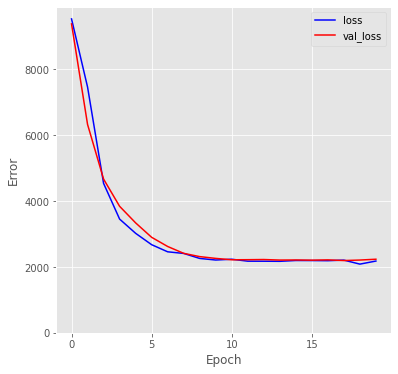

In [34]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss', color='blue')
    plt.plot(history.history['val_loss'], label='val_loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.ylim(bottom=0)
    plt.locator_params(integer=True)
    plt.legend()
  
plt.figure(figsize=(6, 6))
plot_loss(history)

## Test the model

- Run the final cell below to check the model's performance. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

- To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

- The final cell will also predict expenses using the `test_dataset` and graph the results.

In [35]:
# RUN THIS CELL TO TEST THE MODEL
# Test model by checking how well the model generalizes using the test set.
mae = model.evaluate(dict(test_dataset), test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
    print("You passed the challenge. Great job!")
else:
    print("The Mean Abs Error must be less than 3500. Keep trying.")

Testing set Mean Abs Error: 2093.52 expenses
You passed the challenge. Great job!


8/8 [==============================] - 0s 3ms/step


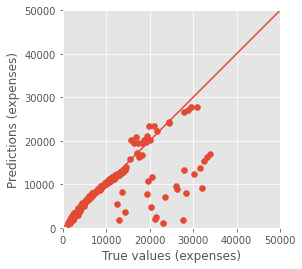

In [36]:
# Plot predictions.
test_predictions = model.predict(dict(test_dataset)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)

## References

1.   [Basic regression: Predict fuel efficiency.](https://www.tensorflow.org/tutorials/keras/regression)
2.   [Classify structured data using Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)

